# Introduction to MIMO

In [1]:
import mdof
from mdof import modal, transform
import numpy as np
from numpy import sqrt
from mdof.utilities.config import Config
from mdof.utilities.printing import plot_io, print_modes, plot_transfer, plot_pred
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(["science"])

## Unknown multi-input, multi-output system
parameter | value
----------|-------
$m_{1}$  | mass at dof 1
$m_{2}$  | mass at dof 2
$k_{1}$  | stiffness at dof 1
$k_{2}$  | stiffness at dof 2

![2dof](./figures/2dof.png)

### The eigenvalues (natural frequencies squared) of the system under proportional damping* are derived below.

$$a = \frac{m_{1}}{m_{2}}, \quad{} b = \frac{k_{1}}{k_{2}}$$

$$\mathbf{m} = \begin{bmatrix} m_{1} & 0 \\ 0 & m_{2} \end{bmatrix} = m_{2}\begin{bmatrix} a & 0 \\ 0 & 1 \end{bmatrix}, 
\quad \quad
\mathbf{k} = \begin{bmatrix} k_{1}+k_{2} & -k_{2} \\ -k_{2} & k_{2} \end{bmatrix} = k_{2} \begin{bmatrix} 1+b & -1 \\ -1 & 1 \end{bmatrix}$$

$$\mathbf{m}^{-1}\mathbf{k} = \frac{k_{2}}{am_{2}}\begin{bmatrix} 1+b & -1 \\ -a & a \end{bmatrix} \implies
\begin{aligned} \lambda^{2}+(-a-b-1)\lambda+ab = 0 \\
\omega_{n1}^{2}, \omega_{n2}^{2} = \frac{k_{2}}{am_{2}}\left( \frac{(a+b+1)\pm\sqrt{a^2+b^2-2ab+2a+2b+1}}{2} \right)
\end{aligned}$$

*proportional damping means that $\mathbf{m}^{-1}\mathbf{c} = \Phi \Lambda_{c} \Phi$, where $\Phi$ is the transformation matrix that diagonalizes $\mathbf{m}^{-1}\mathbf{k}$, and $\Lambda_{c}$ is any diagonal matrix.

### The motion of the modal coordinates, $\mathbf{q}$, of the system are related to the system coordinates, $\mathbf{u}$, by the transformation matrix $\Phi$.

### The response to harmonic vibration with viscous damping is expressed below.

In [2]:
# get modal coordinates
def diag2dof(m1, m2, k1, k2):
  m = m2
  k = k2
  a = m1/m2
  b = k1/k2
  kab1 = k*(a + b + 1)/(2*a*m)
  ksqr = k*sqrt(a**2 - 2*a*b + 2*a + b**2 + 2*b + 1)/(2*a*m)
  eigvals = np.array([kab1 - ksqr,  kab1 + ksqr])
  eigvecs = np.array([[1 - m*(kab1 - ksqr)/k,   1 - m*(kab1 + ksqr)/k],
                      [1, 1]])  
  return eigvals, eigvecs

# displacement response (analytical solution) (output)
def harmonic_sdof(forcing_frequencies, nt, t, k, omega_n, zeta):
  omega_D = omega_n*np.sqrt(1-zeta**2)
  output = np.zeros((len(forcing_frequencies),nt))
  for i,omega in enumerate(forcing_frequencies):
    C3 = (1/k)*(1-(omega/omega_n)**2)/((1-(omega/omega_n)**2)**2+(2*zeta*omega/omega_n))**2
    C4 = -(2*zeta*omega/omega_n)*(1-(omega/omega_n)**2)/((1-(omega/omega_n)**2)**2+(2*zeta*omega/omega_n))**2
    C1 = -C4
    C2 = (zeta*omega_n*C1-omega*C3)/omega_D
    output[i,:] = np.exp(-zeta*omega_n*t)*(C1*np.cos(omega_D*t)+C2*np.sin(omega_D*t)) + C3*np.sin(omega*t) + C4*np.cos(omega*t)
  output = np.sum(output,axis=0)
  return output

def harmonic_2dof(forcing_frequencies, nt, t, m1, m2, k1, k2, zeta1, zeta2):
  ks = [k1, k2]
  zs = [zeta1, zeta2]
  omega_ns, phis = diag2dof(m1, m2, k1, k2)
  outputs = np.empty((2,nt))
  for i in range(2):
    outputs[i] = harmonic_sdof(forcing_frequencies, nt, t, ks[i], omega_ns[i], zs[i])
  outputs = phis@outputs
  return omega_ns, phis, outputs

In [3]:
# parameters of 2DOF system
m1 = 2          # mass
m2 = 1          # mass
ms = [m1, m2]
k1 = 30         # stiffness
k2 = 10         # stiffness
ks = [k1, k2]
zeta1 = 0.01    # damping ratio
zeta2 = 0.02    # damping ratio
zetas = [zeta1, zeta2]

omega_ns, phis = diag2dof(*ms, *ks)

C = phis @ np.diag([2*zeta*omega_n for zeta,omega_n in zip(zetas, omega_ns)])   # damping coefficients
                    
Tns = [2*np.pi/omega_n for omega_n in omega_ns]
print(f"natural periods: {Tns[0]:<3.3}s, {Tns[1]:<3.3}s")
print(f"damping ratios: {zeta1}, {zeta2}")
print(f"damping matrix: {C}")

natural periods: 0.991s, 0.266s
damping ratios: 0.01, 0.02
damping matrix: [[ 0.04641016 -1.29282032]
 [ 0.12679492  0.94641016]]


In [4]:
# forcing function (input)
nt = 2000       # number of timesteps
dt = 0.03       # timestep
tf = nt*dt      # final time
t = np.arange(start = 0, stop = tf, step = dt)  # times
forcing_frequencies = [0.5*omega_ns[0]] # [0.017*omega_ns[0], 0.14*omega_ns[0], 0.467*omega_ns[0], 0.186*omega_ns[0], 0.2937*omega_ns[0]]  # forcing frequencies (rad/s)
inputs = np.sum(np.sin([omega*t for omega in forcing_frequencies]), axis=0)

In [5]:
# displacement response (output)
_, _, outputs = harmonic_2dof(forcing_frequencies, nt, t, *ms, *ks, *zetas)

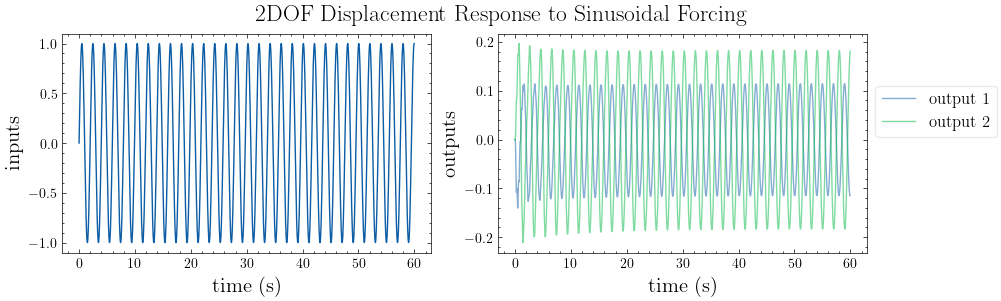

In [6]:
# plot input vs. output
fig = plot_io(inputs=inputs, outputs=outputs, t=t, title="2DOF Displacement Response to Sinusoidal Forcing")

## Configure

In [7]:
conf = Config()
conf.order = 4             # Model order for state space methods.  Equals 2x the number of modes.
conf.period_band = (0.1,3) # Period band (s), periods considered for fourier transfer function

## Analysis with System Identification

### Modal Estimation

Spectral quantities:
       T(s)        ζ        EMACO      MPC       EMACO*MPC
      0.9911     0.01       1.0        1.0        1.0      
      0.2656     0.02       1.0        1.0        1.0      
Mean Period(s): 0.6283185307179744
Standard Dev(s): 0.3627598728468329


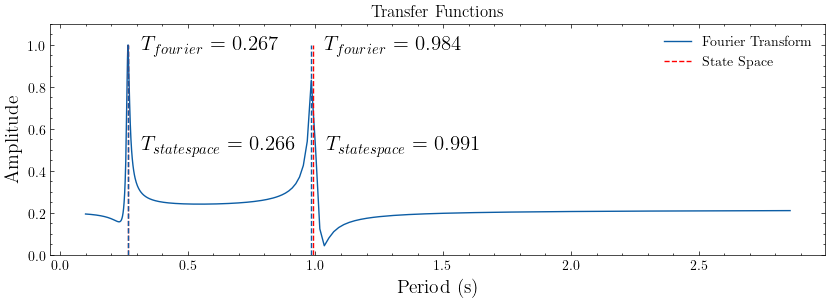

In [8]:
# A place to store models and their predictions
transfer_models = {}

# Generate a transfer function representation of the system
transfer_models["Fourier Transform"] = transform.fourier_transfer(inputs, outputs[0], dt, **conf)

# Determing the fundamental frequency
fourier_periods, fourier_amplitudes = modal.spectrum_modes(*transfer_models["Fourier Transform"])

# Generate a state space realization of the system
realization = mdof.system(method="srim", inputs=inputs, outputs=outputs, **conf)
# Obtain natural period and damping ratio from the state space model
ss_modes = modal.system_modes(realization, dt, method='okid-era-dc',**conf)
ss_periods = [1/f for f in [ss_modes[mode]["freq"] for mode in ss_modes.keys()]]
print_modes(ss_modes)

plot_transfer(transfer_models, title="Transfer Functions")
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.gcf().axes[0].vlines(ss_periods[:2],0,1,linestyles='--',colors='r',label='State Space')
plt.gcf().axes[0].vlines([*fourier_periods[:2]],ymin=0,ymax=1,linestyles='--',colors=color_cycle[0])
for i in range(2):
    plt.gcf().axes[0].text(fourier_periods[i]+0.05,0.975,r"$T_{fourier}$ = "+str(np.round(fourier_periods[i],3)),fontsize=15)
    plt.gcf().axes[0].text(ss_periods[i]+0.05,0.5,r"$T_{state space}$ = "+str(np.round(ss_periods[i],3)),fontsize=15)
plt.gcf().set_figwidth(10)
plt.gcf().axes[0].legend()
plt.gcf().axes[0].set_ylim((0,1.1));

### Response Prediction

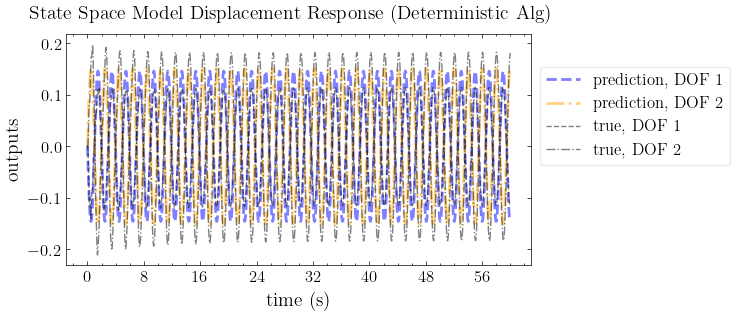

In [9]:
# Reproduce the response with the state space model
inputs = np.atleast_2d(inputs)
outputs = np.atleast_2d(outputs)
A,B,C,D= mdof.realize.deterministic(inputs,outputs,i=10,j=1800)
A = mdof.validation.stabilize_discrete(A)
realization = (A,B,C,D)
out_pred = mdof.simulate.simulate(realization,inputs)
fig = plot_pred(ytrue=outputs, models=out_pred, t=t, title="State Space Model Displacement Response (Deterministic Alg)")

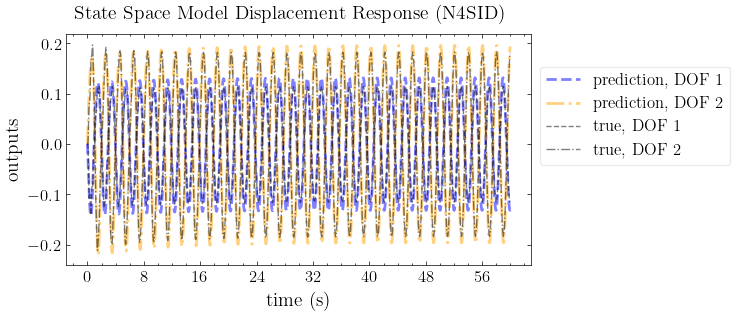

In [23]:
# Reproduce the response with the state space model
inputs = np.atleast_2d(inputs)
outputs = np.atleast_2d(outputs)
A,B,C,D, Q,S,R = mdof.realize.n4sid(inputs,outputs,i=10,j=1800)
A = mdof.validation.stabilize_discrete(A)
realization = (A,B,C,D)
out_pred = mdof.simulate.simulate(realization,inputs)
fig = plot_pred(ytrue=outputs, models=out_pred, t=t, title="State Space Model Displacement Response (N4SID)")

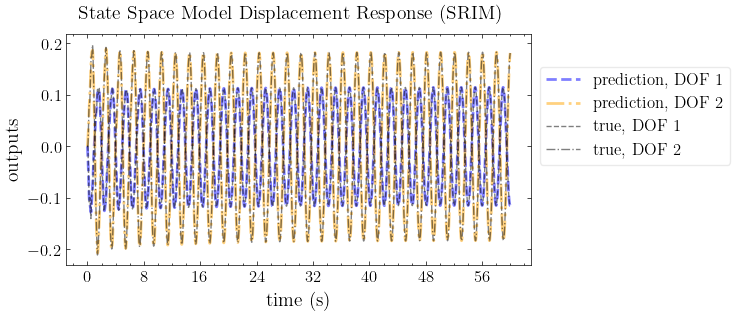

In [11]:
# Reproduce the response with the state space model
from control import ss, forced_response
realization = mdof.system(method="srim", inputs=inputs, outputs=outputs, **conf)
out_pred = forced_response(ss(*realization,dt), U=inputs, squeeze=False, return_x=False).outputs
fig = plot_pred(ytrue=outputs, models=out_pred, t=t, title="State Space Model Displacement Response (SRIM)")

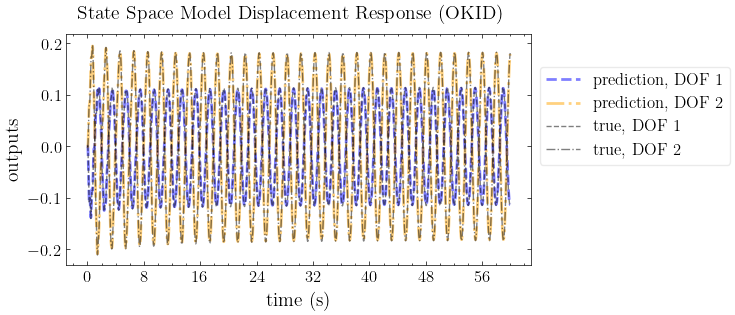

In [12]:
# Reproduce the response with the state space model
from control import ss, forced_response
realization = mdof.system(method="okid-era-dc", inputs=inputs, outputs=outputs, **conf)
out_pred = forced_response(ss(*realization,dt), U=inputs, squeeze=False, return_x=False).outputs
fig = plot_pred(ytrue=outputs, models=out_pred, t=t, title="State Space Model Displacement Response (OKID)")